In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from tqdm import tqdm
import pickle

# module containing the main functions
import utils as ut
import utils_phase_diagr as ut_pd

## Studying the dependency of the response on the inhibition strength

Here the only variable parameter is $\alpha_0$, determining $\beta_0$ from fixing the time of max expansion

In [2]:
# Parameters

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 100000, 'adapt', 25

# Memory stopping condition parameter
theta = 0.2  

# Time of max expansion
t_T_max = 9

# Tollerance on the time of max expansion
t_T_max_tol = 0.1

# Number of realizations in an ensemble for the two procedures
R_beta0, R_obs = 200, 2000

In [5]:
def get_t_T_max_beta0(alpha0, beta0):
    ensamble = ut_pd.generate_ensamble(R_beta0, tau_samp, t_steps, dt, traj_steps, theta, print_progress=False, alpha0=alpha0, beta0=beta0)
    _, _, T_tot_mat, times_mat = ensamble
    return np.mean([times_mat[r][np.argmax(T_tot_mat[r])] for r in range(R_beta0)])

In [6]:
# First, for each alpha0, we find the beta0 at which the max expasion
# happens at time t_T_max. Results are saved in out_data

alpha0s = np.logspace(-6, -3, 50)

beta0s = []
progress = tqdm(total=len(alpha0s))
for a0 in alpha0s:
    func = lambda x : get_t_T_max_beta0(a0, x) - t_T_max
    beta0s.append(ut.bisection(func, 0.8, 2, t_T_max_tol))
    progress.update(1)

with open(f'out_data/alpha0_dependency/a0s_b0s.pkl', 'wb') as f:
    pickle.dump((alpha0s, beta0s), f)

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [1:06:43<04:34, 137.20s/it]

You have not assumed right a and b in bisection:
f(a)=-0.3487500000000008, f(b)=-2.99


 98%|█████████▊| 49/50 [1:07:42<01:53, 113.63s/it]

You have not assumed right a and b in bisection:
f(a)=-0.6362500000000004, f(b)=-3.05875


100%|██████████| 50/50 [1:08:41<00:00, 97.16s/it] 

You have not assumed right a and b in bisection:
f(a)=-1.1637500000000003, f(b)=-3.35375


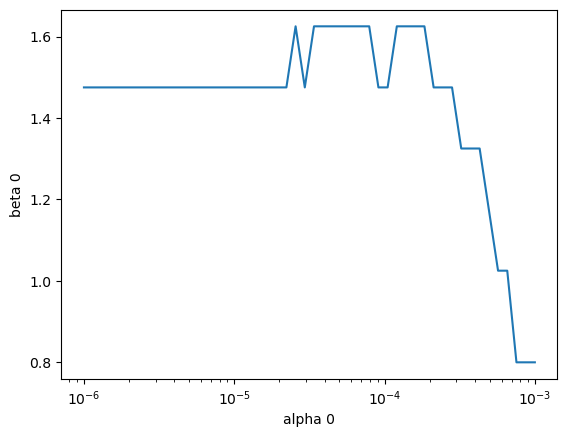

In [16]:
plt.xscale('log')
plt.xlabel('alpha 0')
plt.ylabel('beta 0')
plt.plot(alpha0s, beta0s)

In [ ]:
# Second, we compute the observables for the alpha0-beta0
# pairs found at the step before. Again, data saved in out_data

data = pickle.load(open(f'out_data/alpha0_dependency/a0s_b0s.pkl', 'rb'))
alpha0s, beta0s = data

T_maxs, t_T_maxs, inv_simpss, x_maxs = [], [], [], []
progress = tqdm(total=len(alpha0s))
for i, a0 in enumerate(alpha0s):

    # Generating ensamble
    ensamble = ut_pd.generate_ensamble(R_obs, tau_samp, t_steps, dt, traj_steps, theta, print_progress=False, alpha0=a0, beta0=beta0s[i])
    taus_mat, Ts_mat, T_tot_mat, times_mat = ensamble

    if a0 > 5e-4: qt = 0.995 # Setting the sensitivty to outliers depending on alpha0)
    else: qt = 0.999
    x_max, y_max, n_x_max, outcome = ut_pd.find_max(taus_mat, Ts_mat, smooth_bins=50, quantile_taus=qt)
    
    x_maxs.append(x_max)
    T_maxs.append(np.mean([np.max(Ttot) for Ttot in T_tot_mat]))
    t_T_maxs.append(np.mean([times_mat[r][np.argmax(T_tot_mat[r])] for r in range(R_obs)]))
    inv_simpss.append(ut_pd.compute_inv_simps(Ts_mat))

    progress.update(1)


# Saving results
with open(f'out_data/alpha0_dependency/observables.pkl', 'wb') as f:
    pickle.dump((T_maxs, t_T_maxs, inv_simpss, x_maxs), f)

# Saving parameters
pars = ut.TT_params([1])  # just to have access to default parameters
other_params = {'theta_stop': theta, 't_T_max': t_T_max, 't_T_max_tol': t_T_max_tol, 'R_beta0' : R_beta0, 'R_obs' : R_obs,}
other_params = {**tau_samp.get_pars(), **other_params}
pars.print_on_file('out_data/alpha0_dependency/', 'pars', other_params)


100%|██████████| 50/50 [1:11:19<00:00, 85.60s/it]
/home/andrea/Scrivania/TT-inhibition/utils_phase_diagr.py:118: RuntimeWarning: divide by zero encountered in scalar divide
  inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])


In [3]:
# Loading all data

data = pickle.load(open(f'out_data/alpha0_dependency/a0s_b0s.pkl', 'rb'))
alpha0s, beta0s = data
data = pickle.load(open(f'out_data/alpha0_dependency/observables.pkl', 'rb'))
T_maxs, t_T_maxs, inv_simpss, x_maxs = data
params = pd.read_csv(f'out_data/alpha0_dependency/pars.tsv', sep='\t', header=None, index_col=0)[1].to_dict()
factors = np.array(T_maxs) / params['n_samples']

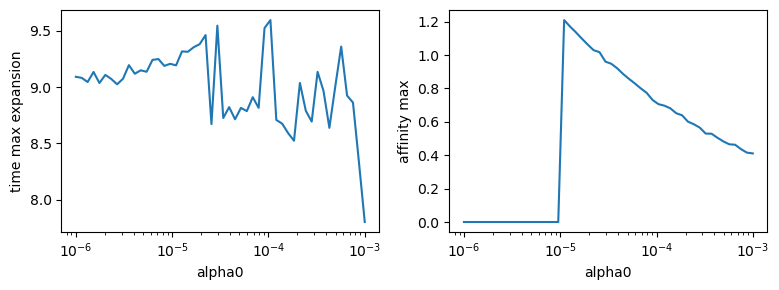

In [4]:
# Plot for a sanity check on the time of max expansion that has to be 
# around the desired value. 
# Plotting also the affinity that gives the maximum abundance (and when the relation 
# is monotonous instead)
 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3))

for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_xlabel('alpha0')

ax1.set_ylabel('time max expansion')
ax1.plot(alpha0s, t_T_maxs)

ax2.set_ylabel('affinity max')
aux = np.where(np.isnan(x_maxs), 0, x_maxs)
ax2.plot(alpha0s, aux)

plt.tight_layout()

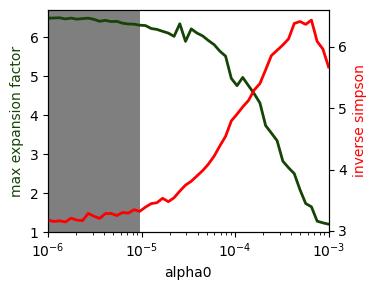

In [6]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.set_xscale('log')
ax1.set_xlabel('alpha0')
ax1.set_xlim(alpha0s[0], alpha0s[-1])

c1, c2 = '#154406', 'r'
ax2 = ax1.twinx()

# Create a Rectangle patch
factors = np.array(T_maxs) / params['n_samples']
first_max_i = list(~np.isnan(x_maxs)).index(True)
w = alpha0s[first_max_i-1] - alpha0s[0]
rect = patches.Rectangle((alpha0s[0], 1), w, max(factors)-0.8, linewidth=1, facecolor='k', alpha=0.5)

# Add the patch to the Axes
ax1.add_patch(rect)

ax1.set_ylabel('max expansion factor', color=c1)
ax1.plot(alpha0s, factors, c=c1, lw=2)
ax1.set_ylim(1, max(factors)+0.2)

ax2.set_ylabel('inverse simpson', color=c2)
ax2.plot(alpha0s, inv_simpss, c=c2, lw=2)

plt.tight_layout()
plt.savefig('plots/alpha0_dependency.png', dpi=200, facecolor='w')

12